<a href="https://colab.research.google.com/github/asadbek08/DataScienceMohirdev/blob/main/ML_Ticket_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This model predicts ticket prices from given different information.***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [3]:
df_train = pd.read_csv('./train_data.csv')
df_train.head()

id   airline   flight source_city departure_time stops arrival_time  \
0   1   Vistara   UK-810   Bangalore  Early_Morning   one        Night   
1   2  SpiceJet  SG-5094   Hyderabad        Evening  zero        Night   
2   3   Vistara   UK-846   Bangalore        Morning   one      Evening   
3   4   Vistara   UK-706     Kolkata        Morning   one      Evening   
4   5    Indigo  6E-5394     Chennai  Early_Morning  zero      Morning   

  destination_city     class  duration  days_left  price  
0           Mumbai   Economy     14.25         21   7212  
1          Kolkata   Economy      1.75          7   5292  
2            Delhi  Business      9.58          5  60553  
3        Hyderabad   Economy      6.75         28   5760  
4           Mumbai   Economy      2.00          4  10712

# ***Data Visualization and Analisys***

# airline/flight vs prize

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


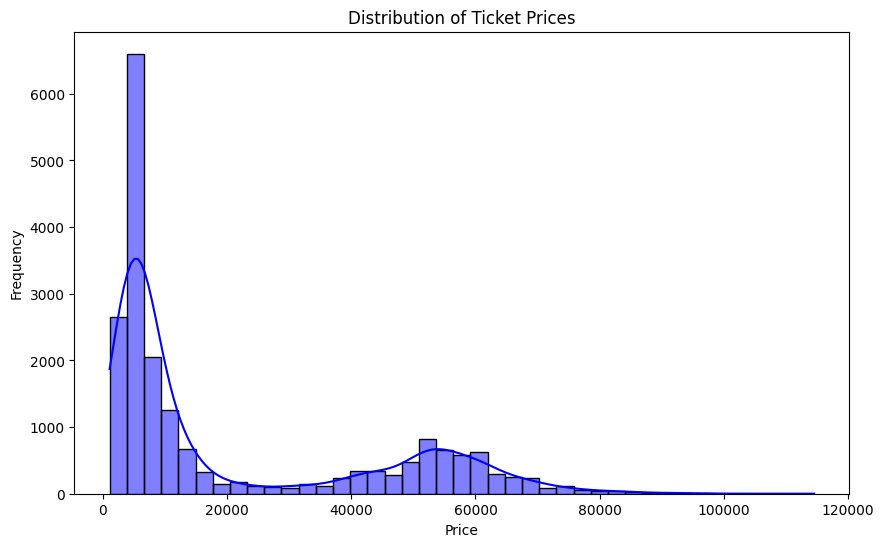

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['price'], kde=True, color='blue')
plt.title('Distribution of Ticket Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# this plot just shows how frequent the tickets prices at different price scales

In [6]:
df_train.isna().sum() # so great data without any null entries

id                  0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [7]:
df_train.airline.unique()

array(['Vistara', 'SpiceJet', 'Indigo', 'Air_India', 'GO_FIRST',
       'AirAsia'], dtype=object)

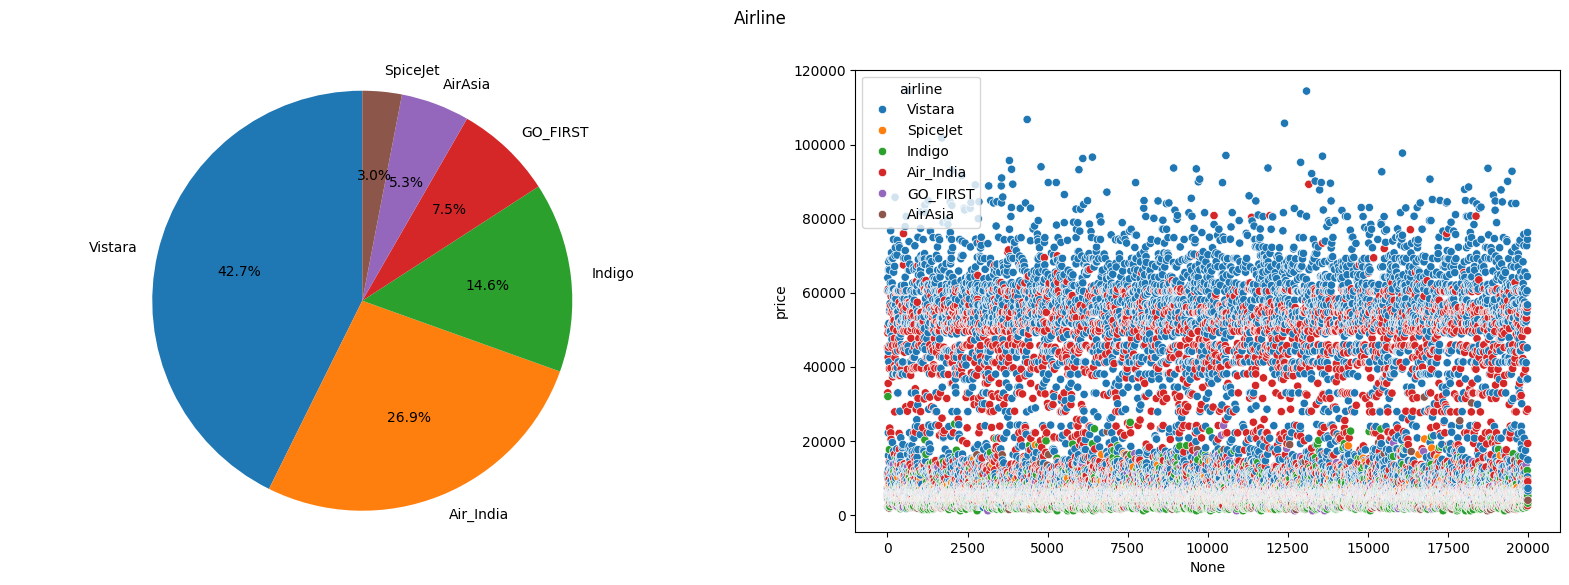

In [8]:
airline_counts = df_train['airline'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Airline")

ax[0].pie(airline_counts, labels=airline_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='airline')
plt.show()
# we can see Vistara airlines rather expensive than other airlines, Air_india is moderate, others are much cheaper.

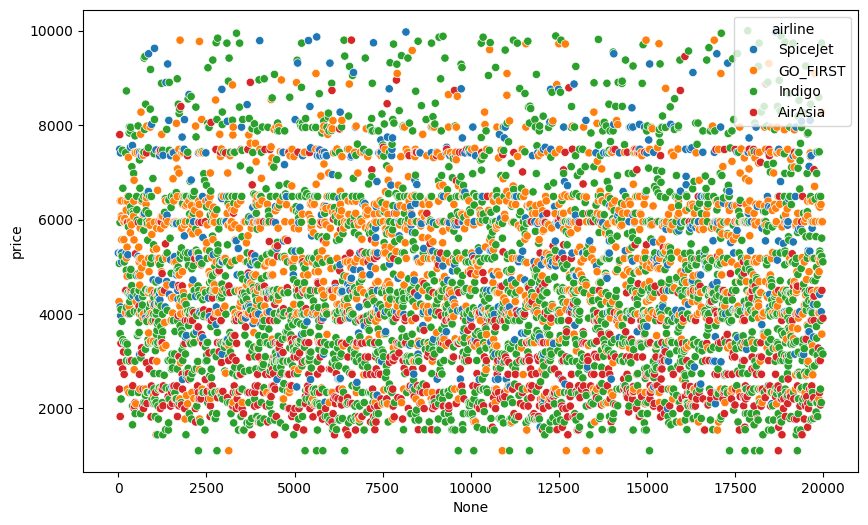

In [9]:
# Lets filter out much cheaper ones to see the difference between them and also remove some higher prices of these companies to see deeply
filtered_df = df_train[
    ~df_train['airline'].isin(["Vistara", "Air_India"]) &
    (df_train['price'] < 10000)
]
airline_counts = filtered_df['airline'].value_counts()

plt.figure(figsize=(10, 6))

sns.scatterplot( data = filtered_df, x=filtered_df.index, y='price', hue='airline')
plt.show()
# we can say differences are least important between them

In [10]:
print(len(df_train.flight.unique()))
sorted_flights = np.sort(df_train['flight'].unique())
df_flights = pd.DataFrame(sorted_flights, columns=['Flight'])
df_flights.head()
#df_flights.head(30)
#df_flights.tail(30)
# we can see from the column that we can use just the 3 beginning chars of the flight names
df_train

1310


id   airline   flight source_city departure_time        stops  \
0          1   Vistara   UK-810   Bangalore  Early_Morning          one   
1          2  SpiceJet  SG-5094   Hyderabad        Evening         zero   
2          3   Vistara   UK-846   Bangalore        Morning          one   
3          4   Vistara   UK-706     Kolkata        Morning          one   
4          5    Indigo  6E-5394     Chennai  Early_Morning         zero   
...      ...       ...      ...         ...            ...          ...   
19995  19996    Indigo  6E-6178   Bangalore          Night          one   
19996  19997   AirAsia   I5-582     Kolkata        Morning          one   
19997  19998   Vistara   UK-832     Chennai  Early_Morning  two_or_more   
19998  19999   Vistara   UK-996      Mumbai        Evening          one   
19999  20000   Vistara   UK-776     Kolkata        Evening          one   

        arrival_time destination_city     class  duration  days_left  price  
0              Night           Mumbai   Economy     14.25         21   7212  
1              Night          Kolkata   Economy      1.75          7   5292  
2            Evening            Delhi  Business      9.58          5  60553  
3            Evening        Hyderabad   Economy      6.75         28   5760  
4            Morning           Mumbai   Economy      2.00          4  10712  
...              ...              ...       ...       ...        ...    ...  
19995  Early_Morning           Mumbai   Economy      7.92         45   3153  
19996      Afternoon            Delhi   Economy      5.83         24   3911  
19997        Evening        Bangalore   Economy     35.33         17  14822  
19998        Morning        Bangalore   Economy     16.33         21   6450  
19999        Morning          Chennai   Economy     18.25         26   7141  

[20000 rows x 12 columns]

In [11]:
# Now we want to see if the individual name of each flight code correlate with prices
import warnings
warnings.filterwarnings('ignore')

slect_only_6E = df_train[df_train['flight'].str[:2] == '6E']
slect_only_6E['flight'] = slect_only_6E['flight'].str[3:]
slect_only_6E['flight'] = pd.to_numeric(slect_only_6E['flight'], errors='coerce')
slect_only_6E.head()

id airline  flight source_city departure_time stops   arrival_time  \
4    5  Indigo    5394     Chennai  Early_Morning  zero        Morning   
13  14  Indigo     634     Kolkata        Morning   one          Night   
28  29  Indigo     345     Kolkata        Morning   one        Evening   
49  50  Indigo    5386      Mumbai        Evening   one     Late_Night   
50  51  Indigo     725     Kolkata        Evening   one  Early_Morning   

   destination_city    class  duration  days_left  price  
4            Mumbai  Economy      2.00          4  10712  
13            Delhi  Economy      9.58          4  31952  
28        Hyderabad  Economy      8.58         28   5070  
49            Delhi  Economy      5.08         11   5939  
50          Chennai  Economy     10.00         35   3583

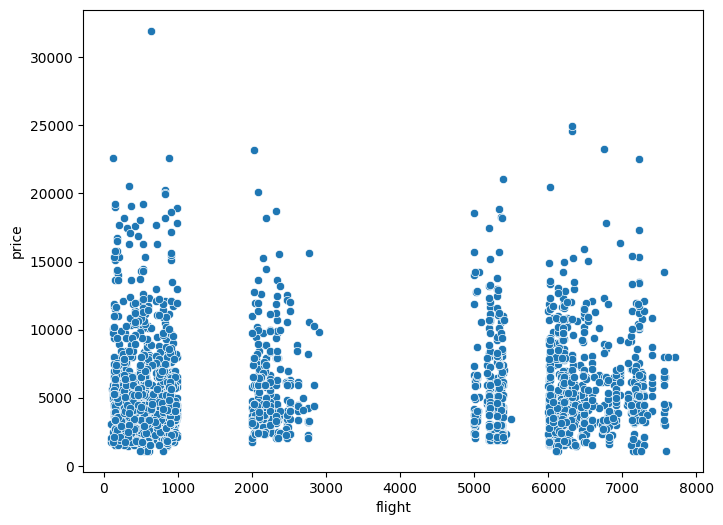

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=slect_only_6E, x='flight', y='price')
plt.show()

#we can see there is no any reletionship between the individual names of flights

In [13]:
df_train['flight'] = df_train['flight'].str[:3]
print(len(df_train.flight.unique()),"\n",len(df_train.airline.unique())) # so good result

6 
 6


In [14]:
# lets see what happens if we group by flight and airline, if our groups are 6, we can say flight and airline corresponds witheach other
df_train.groupby(['flight', 'airline']).size() # now we can drop any of these two columns

flight  airline  
6E-     Indigo       2924
AI-     Air_India    5371
G8-     GO_FIRST     1508
I5-     AirAsia      1056
SG-     SpiceJet      606
UK-     Vistara      8535
dtype: int64

In [15]:
# dropping the flight column
df_train = df_train.drop('flight', axis=1)
df_train.head()

id   airline source_city departure_time stops arrival_time  \
0   1   Vistara   Bangalore  Early_Morning   one        Night   
1   2  SpiceJet   Hyderabad        Evening  zero        Night   
2   3   Vistara   Bangalore        Morning   one      Evening   
3   4   Vistara     Kolkata        Morning   one      Evening   
4   5    Indigo     Chennai  Early_Morning  zero      Morning   

  destination_city     class  duration  days_left  price  
0           Mumbai   Economy     14.25         21   7212  
1          Kolkata   Economy      1.75          7   5292  
2            Delhi  Business      9.58          5  60553  
3        Hyderabad   Economy      6.75         28   5760  
4           Mumbai   Economy      2.00          4  10712

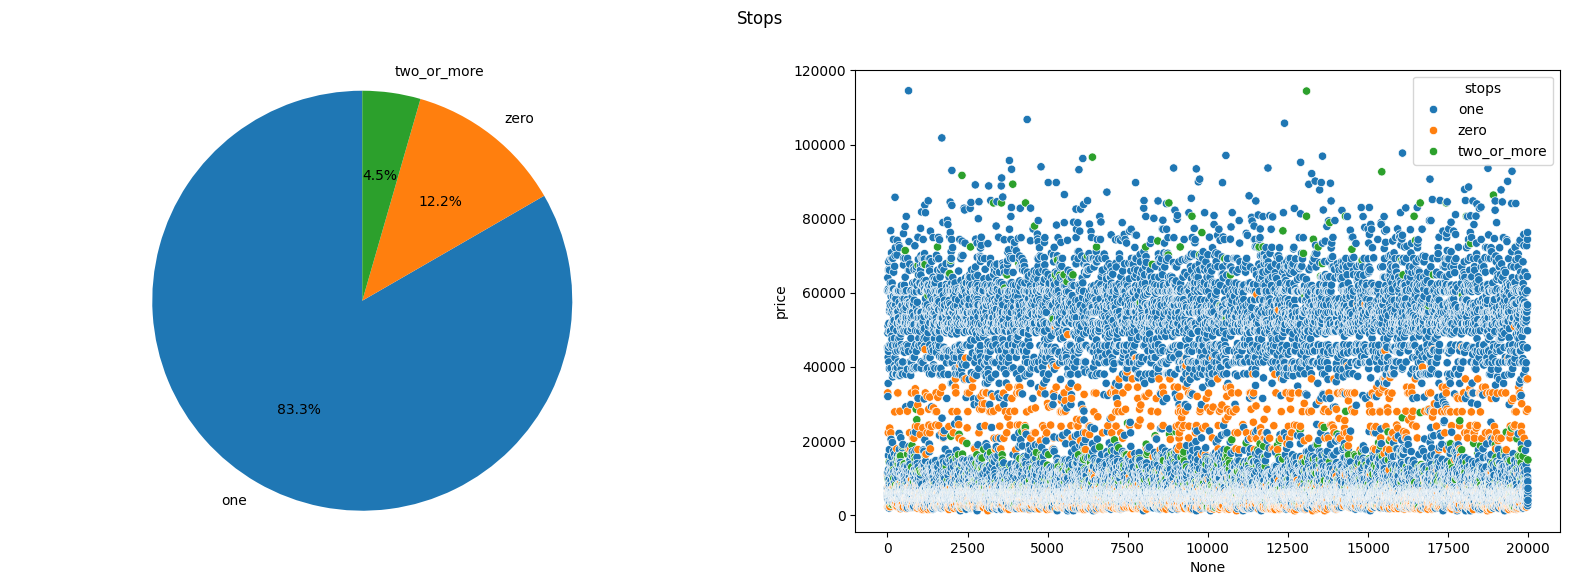

In [16]:
stops_counts = df_train['stops'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Stops")

ax[0].pie(stops_counts, labels=stops_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='stops')
plt.show()
# We can deduce most of the flights has only one stop, and scattered around the plot

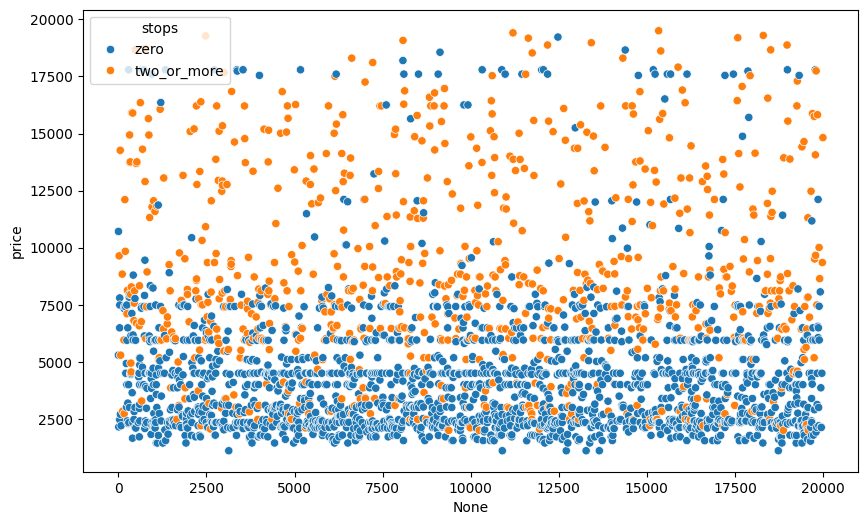

In [17]:
# we have to check if there is correlated difference between zero and two_or_more
filtered_df = df_train[
    (df_train['stops']!="one") &
    (df_train['price'] < 20000)
]
airline_counts = filtered_df['airline'].value_counts()

plt.figure(figsize=(10, 6))

sns.scatterplot( data = filtered_df, x=filtered_df.index, y='price', hue='stops')
plt.show()
# there is a visible difference between all three stop types, thus we should keep the column for modelling

# source_city/destination_city vs price

In [18]:
df_train['source_city'].unique() #we have only few cities we can try to see the correlation

array(['Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Delhi', 'Mumbai'],
      dtype=object)

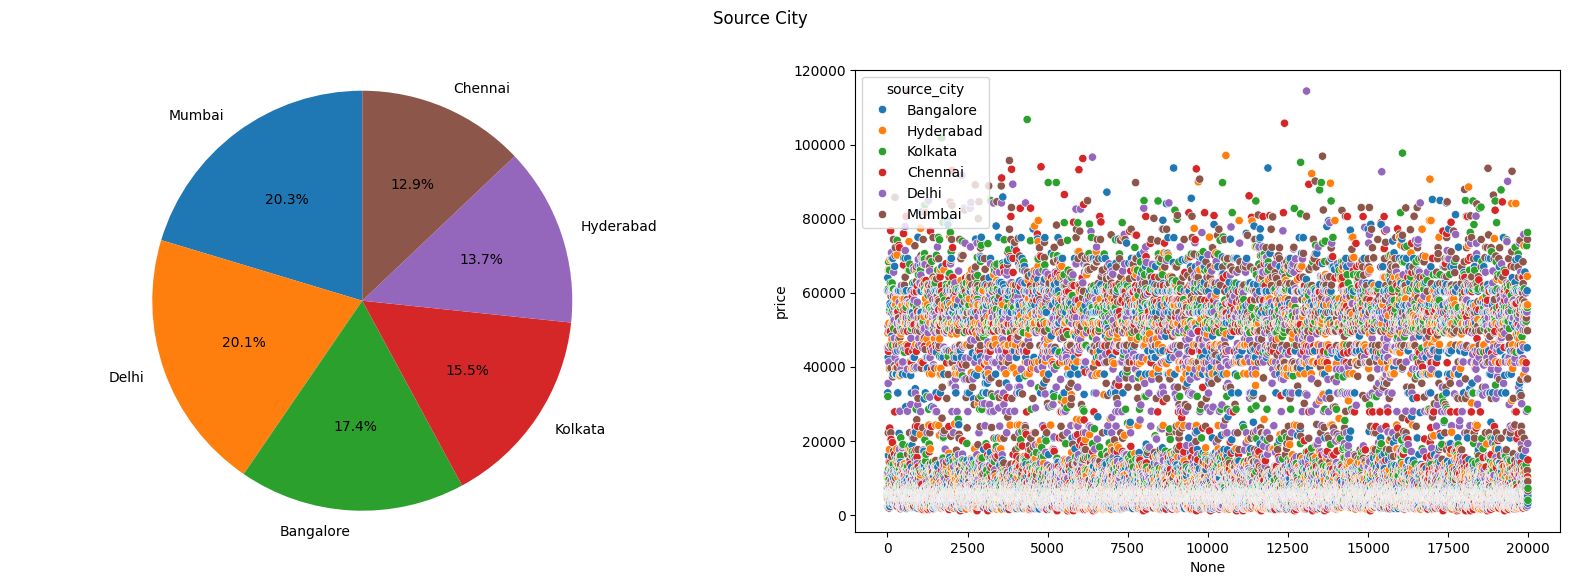

In [19]:
sc_counts = df_train['source_city'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Source City")

ax[0].pie(sc_counts, labels=sc_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='source_city')
plt.show()

# Seems not enough correlation

In [20]:
df_train['destination_city'].unique()

array(['Mumbai', 'Kolkata', 'Delhi', 'Hyderabad', 'Chennai', 'Bangalore'],
      dtype=object)

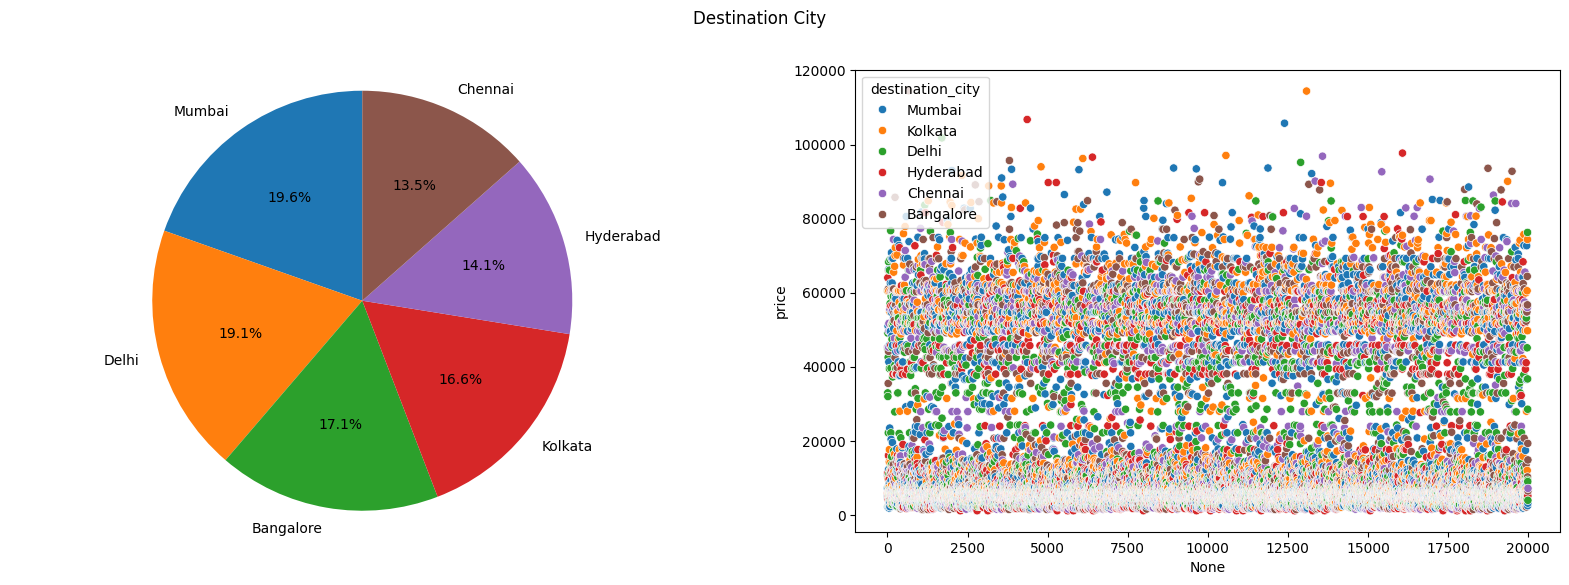

In [21]:
sc_counts = df_train['destination_city'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Destination City")

ax[0].pie(sc_counts, labels=sc_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='destination_city')
plt.show()

# Seems not enough correlation here too

In [22]:
# Logically speaking merging the destination and source city should give enough correlation
df_train.groupby(['source_city', 'destination_city']).size()
merged_df = df_train.copy()
merged_df["src_des"] = df_train["source_city"] + "_" + df_train["destination_city"]
merged_df.head()

id   airline source_city departure_time stops arrival_time  \
0   1   Vistara   Bangalore  Early_Morning   one        Night   
1   2  SpiceJet   Hyderabad        Evening  zero        Night   
2   3   Vistara   Bangalore        Morning   one      Evening   
3   4   Vistara     Kolkata        Morning   one      Evening   
4   5    Indigo     Chennai  Early_Morning  zero      Morning   

  destination_city     class  duration  days_left  price            src_des  
0           Mumbai   Economy     14.25         21   7212   Bangalore_Mumbai  
1          Kolkata   Economy      1.75          7   5292  Hyderabad_Kolkata  
2            Delhi  Business      9.58          5  60553    Bangalore_Delhi  
3        Hyderabad   Economy      6.75         28   5760  Kolkata_Hyderabad  
4           Mumbai   Economy      2.00          4  10712     Chennai_Mumbai

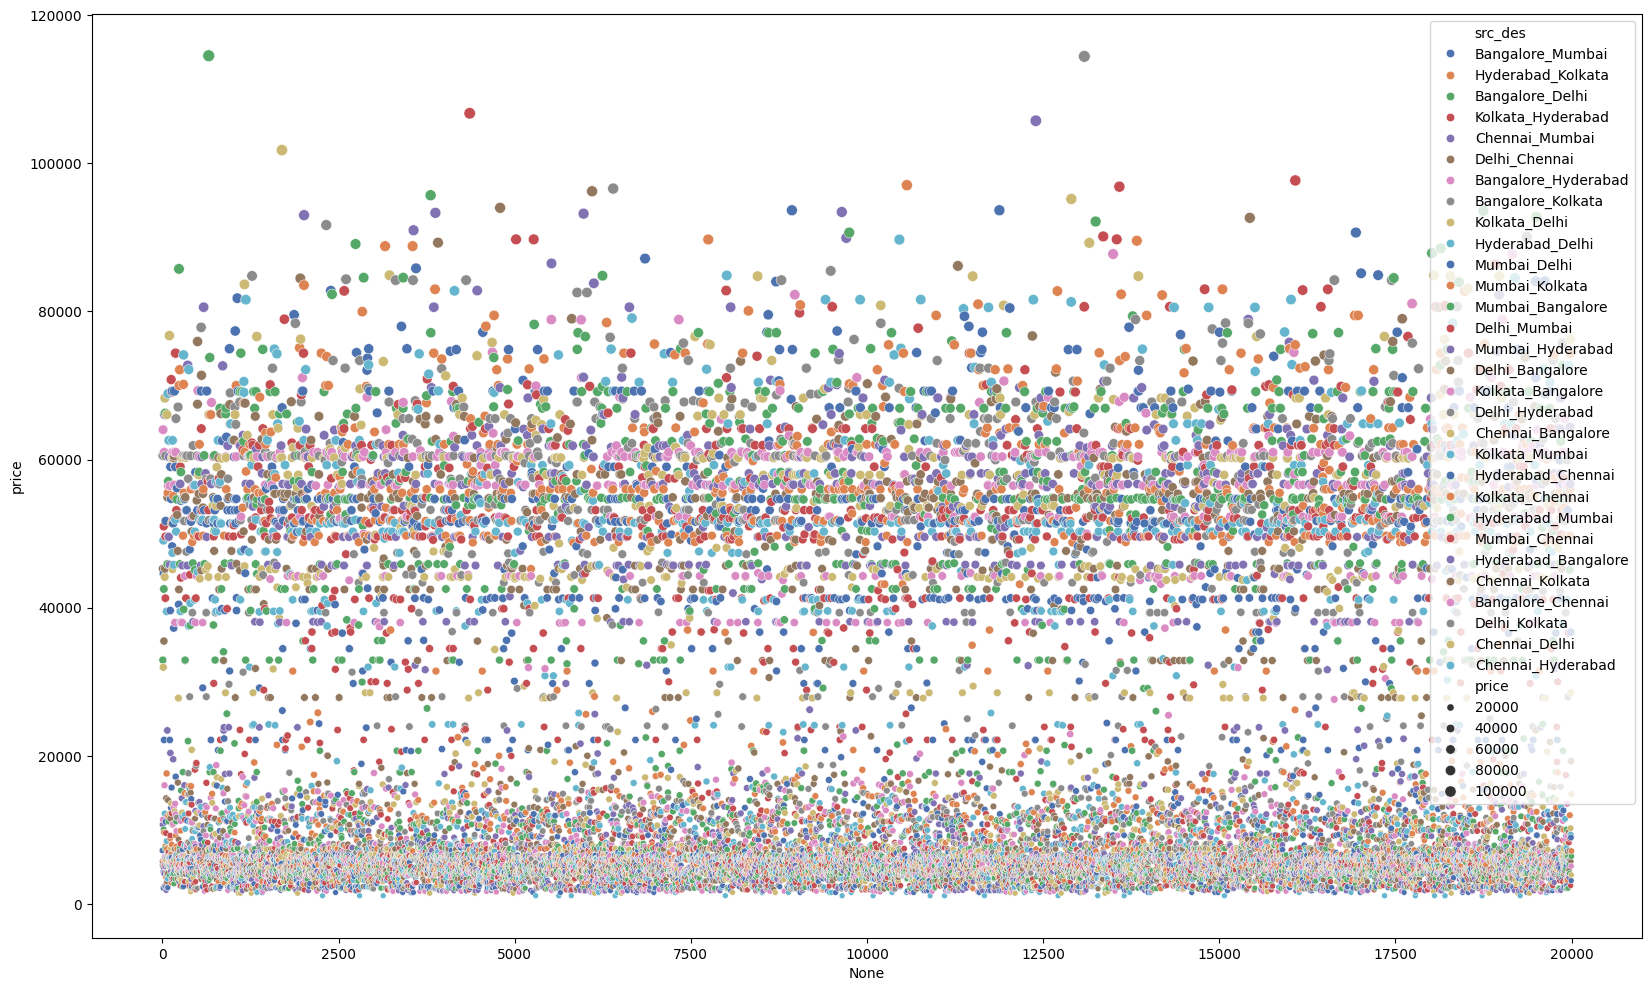

In [27]:
plt.figure(figsize=(20,12))

sns.scatterplot(data = merged_df, x=merged_df.index, y='price', hue='src_des', size="price" ,palette = "deep")
plt.show()

# Seems not enough correlation, we will see after encoding the text into numerical data

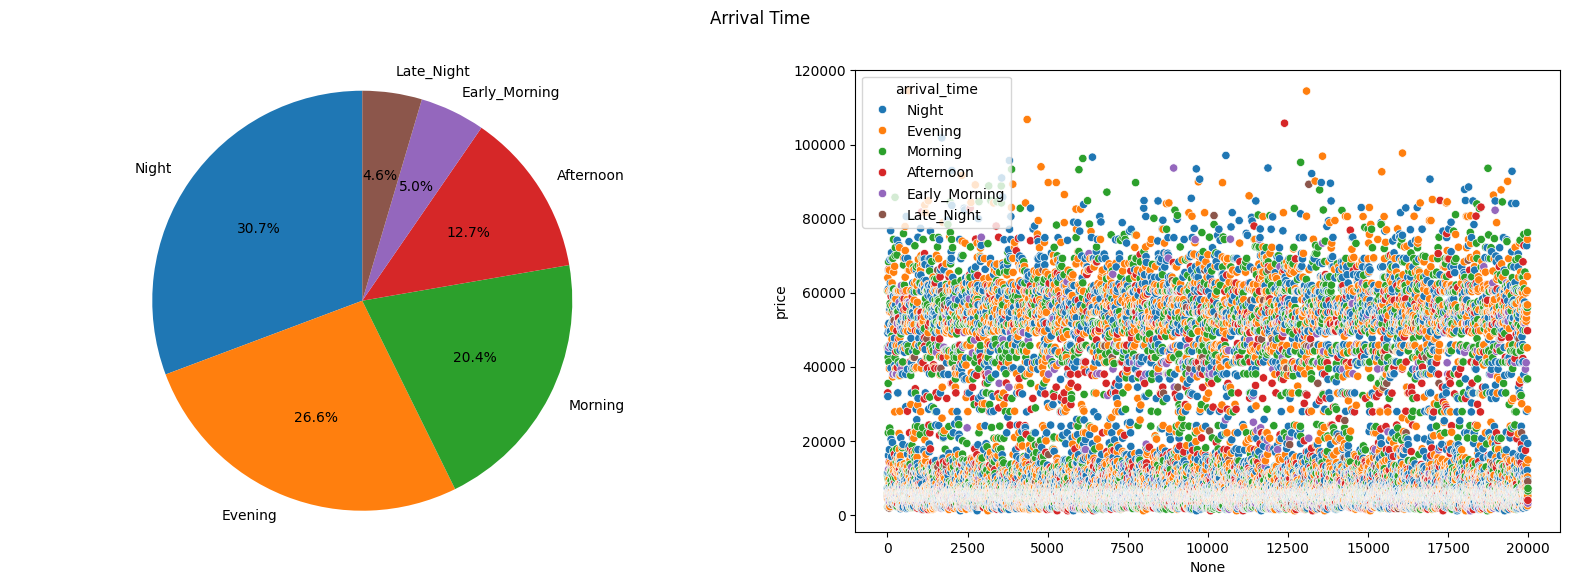

In [31]:
arrival_time_counts = df_train['arrival_time'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Arrival Time")

ax[0].pie(arrival_time_counts, labels=arrival_time_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='arrival_time')
plt.show()

# Seems not much correlation, thus should be no correlation with departure_time column

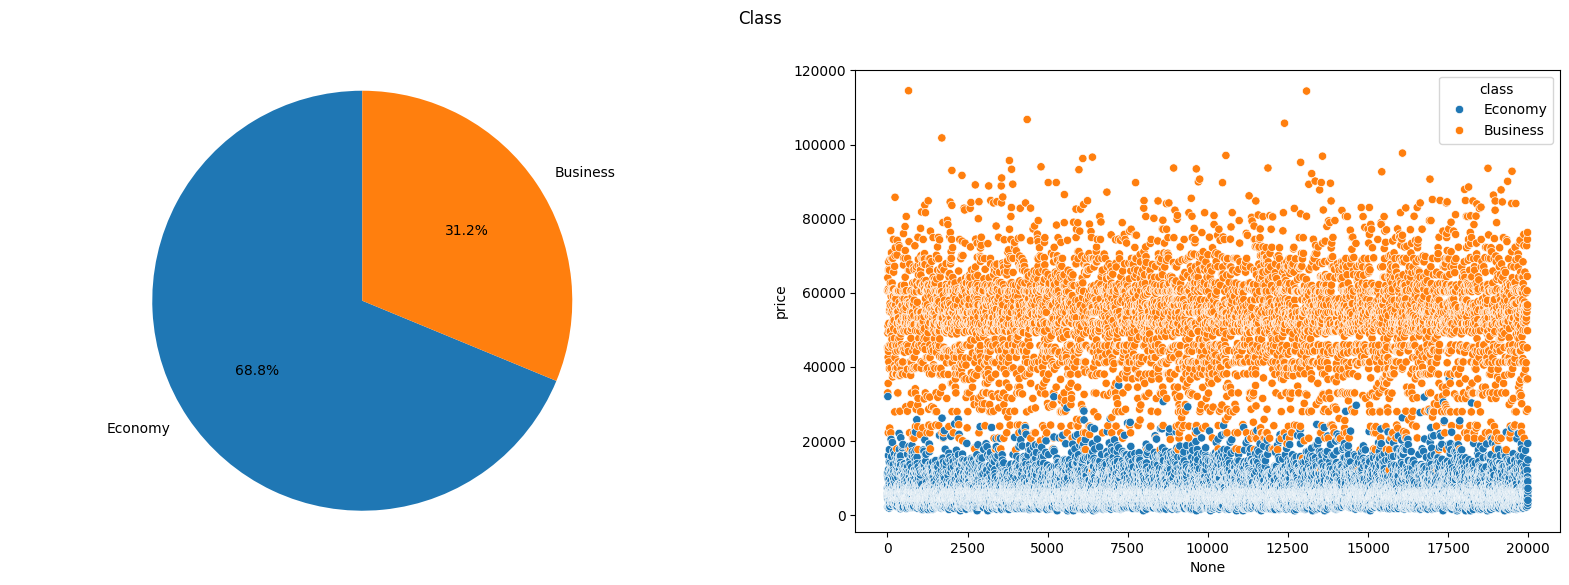

In [32]:
class_counts = df_train['class'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Class")

ax[0].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = df_train, x=df_train.index, y='price', hue='class')
plt.show()
# there is a strong correlation between two categories, and borderline is at around 2000 rupees

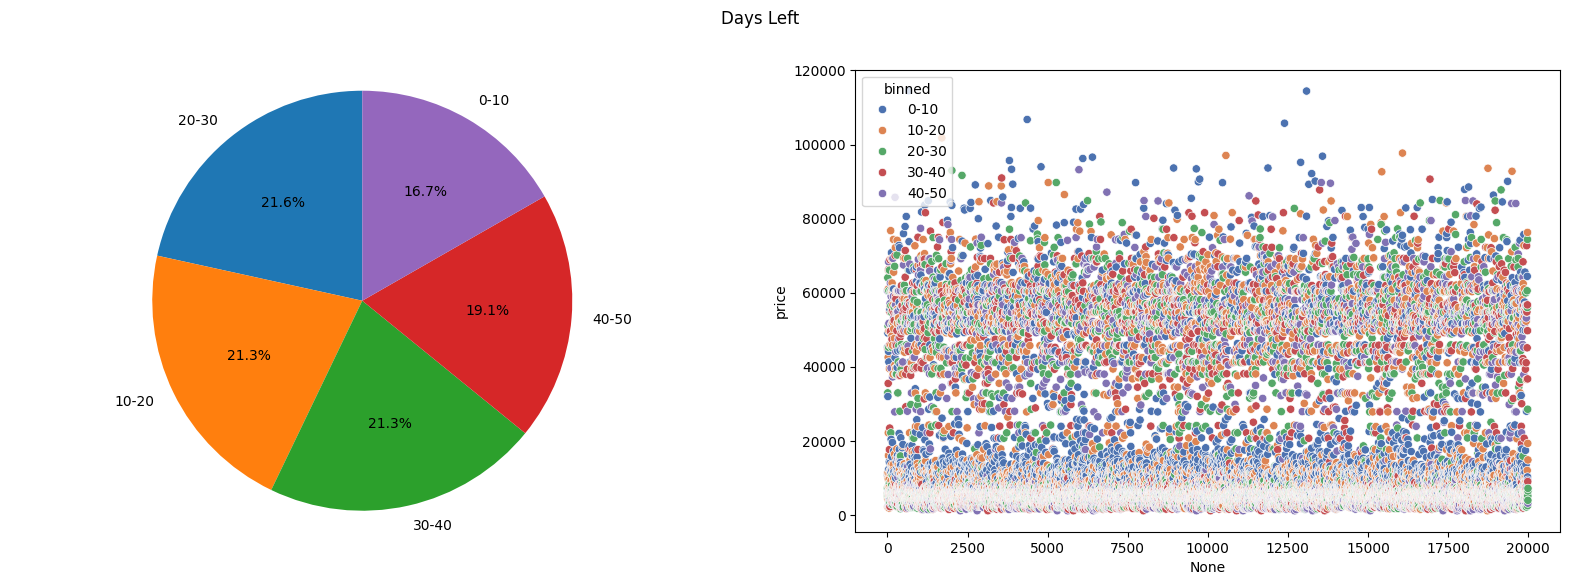

In [38]:
interval_df = df_train.copy()
interval_df['binned'] = pd.cut(interval_df['days_left'], bins=[0, 10, 20, 30, 40, 50], labels=['0-10', '10-20', '20-30', '30-40', '40-50'])

days_counts = interval_df['binned'].value_counts()
fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle("Days Left")

ax[0].pie(days_counts, labels=days_counts.index, autopct='%1.1f%%',startangle=90)
ax[0].axis('equal')

sns.scatterplot(ax=ax[1], data = interval_df, x=interval_df.index, y='price', hue='binned', palette="deep")
plt.show()

In [29]:
X = df_train.drop('price', axis=1)
X = X.drop('id', axis=1)
y = df_train['price']


In [ ]:
Categorical_part = X.select_dtypes(include=['object']).columns.to_list()
Numerical_part = X.select_dtypes(include=np.number).columns.to_list()

In [ ]:
numerical_transfrom = StandardScaler()
categorical_transform = Pipeline([
    ('one_hot', OneHotEncoder())
])

In [ ]:
processor = ColumnTransformer([
    ('num', numerical_transfrom, Numerical_part),
    ('cat', categorical_transform, Categorical_part)
])

In [ ]:
pipeline = Pipeline([
    ('preprocessor', processor)
])

In [ ]:
X_prepared = pipeline.fit_transform(X)

In [ ]:

RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

In [ ]:
X_test = pd.read_csv('./test_data.csv')
X_test['flight'] = X_test['flight'].str[:3]
X_test_prepared = pipeline.fit_transform(X_test)

In [ ]:
y_test_predicted = RF_model.predict(X_test_prepared)

In [ ]:
ids = range(1, len(y_test_predicted) + 1)
rf_df = pd.DataFrame({
    'id' : ids,
    'price': y_test_predicted
})
rf_df.to_csv('submission.csv', index=False)
rf_df

id     price
0        1  52904.67
1        2  56079.18
2        3  22892.78
3        4   3193.78
4        5   6093.69
...    ...       ...
4995  4996  58262.13
4996  4997   4499.67
4997  4998  50377.60
4998  4999  40511.80
4999  5000  67933.19

[5000 rows x 2 columns]